In [15]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y


def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_RBF.xlsx")

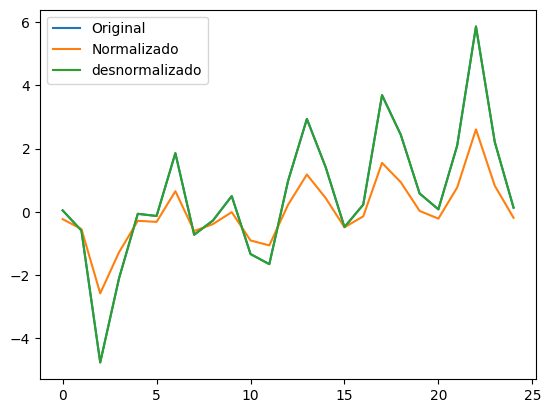

In [16]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [17]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [18]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

In [19]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [20]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_4,0.814413,0.622207,0.732207,0.668161,0.772645,2.526301,0.957880,0.639279,1.833867,0.879002,0.747285,0.892846,34.515872,71.480455
model_1_1_3,0.800158,0.607531,0.723725,0.670867,0.831989,2.624445,0.988219,0.634064,1.826024,0.912134,0.727875,0.926499,34.367873,71.332457
model_1_1_2,0.784894,0.594132,0.711323,0.659331,0.895539,2.714040,1.032581,0.656290,1.880111,0.946329,0.707089,0.961233,34.220658,71.185242
model_1_1_1,0.748298,0.561845,0.681437,0.641243,1.047898,2.929944,1.139481,0.691135,1.947891,1.023669,0.657256,1.039791,33.906427,70.871011
model_1_1_0,0.693274,0.516937,0.631201,0.601582,1.276975,3.230242,1.319174,0.767540,2.077833,1.130033,0.582330,1.147830,33.511012,70.475595


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.896688,0.699367,0.776612,0.921439,0.430114,2.010331,0.799046,0.269862,1.419169,0.655830,0.859320,0.666159,35.687412,72.651996
model_1_2_8,0.892045,0.694190,0.776128,0.920367,0.449443,2.044954,0.800777,0.273544,1.443635,0.670405,0.852997,0.680963,35.599492,72.564076
model_1_2_7,0.880678,0.682833,0.771858,0.917395,0.496767,2.120897,0.816051,0.283752,1.521050,0.704817,0.837519,0.715917,35.399267,72.363851
model_1_2_6,0.879583,0.681546,0.771885,0.916876,0.501324,2.129502,0.815952,0.285535,1.521820,0.708042,0.836028,0.719193,35.381007,72.345590
model_1_2_5,0.878283,0.680359,0.771141,0.916526,0.506737,2.137439,0.818615,0.286738,1.532072,0.711854,0.834258,0.723065,35.359528,72.324111
model_1_2_4,0.877379,0.679460,0.770796,0.916210,0.510500,2.143456,0.819851,0.287822,1.536881,0.714493,0.833027,0.725746,35.344728,72.309311
model_1_2_3,0.865184,0.668091,0.764315,0.911968,0.561271,2.219475,0.843031,0.302394,1.614430,0.749180,0.816421,0.760979,35.155104,72.119688
model_1_2_2,0.848627,0.653564,0.753493,0.905559,0.630204,2.316622,0.881743,0.324411,1.720037,0.793854,0.793875,0.806356,34.923423,71.888007
model_1_2_1,0.834178,0.641065,0.743653,0.898964,0.690357,2.400201,0.916937,0.347065,1.797935,0.830877,0.774200,0.843963,34.741092,71.705675
model_1_2_0,0.833876,0.640541,0.744030,0.898448,0.691613,2.403704,0.915588,0.348837,1.790767,0.831633,0.773789,0.844730,34.737458,71.702042


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.923976,0.731161,0.776189,0.510206,0.316506,1.797726,0.800558,0.450443,1.099660,0.562588,0.896478,0.571449,36.300829,73.265412
model_1_3_8,0.921808,0.728013,0.777957,0.514180,0.325534,1.818775,0.794235,0.446788,1.124042,0.570556,0.893525,0.579542,36.244575,73.209159
model_1_3_7,0.918936,0.724425,0.778686,0.513529,0.337488,1.842774,0.791628,0.447387,1.170482,0.580938,0.889615,0.590087,36.172448,73.137032
model_1_3_6,0.918350,0.723729,0.778732,0.513083,0.339930,1.847425,0.791463,0.447797,1.179602,0.583035,0.888817,0.592217,36.158034,73.122618
model_1_3_5,0.916759,0.721701,0.779281,0.515085,0.346553,1.860984,0.789499,0.445956,1.201363,0.588688,0.886650,0.597959,36.119438,73.084022
model_1_3_4,0.915319,0.719551,0.780591,0.523344,0.352547,1.875362,0.784813,0.438360,1.215153,0.593757,0.884690,0.603108,36.085142,73.049725
model_1_3_3,0.914644,0.718762,0.780604,0.523353,0.355357,1.880637,0.784767,0.438352,1.224089,0.596118,0.883771,0.605507,36.069264,73.033847
model_1_3_2,0.907744,0.712330,0.776652,0.497718,0.384083,1.923652,0.798902,0.461928,1.329293,0.619744,0.874375,0.629505,35.913793,72.878377
model_1_3_1,0.905463,0.708945,0.778419,0.515007,0.393581,1.946284,0.792582,0.446028,1.340836,0.627360,0.871269,0.637240,35.864938,72.829521
model_1_3_0,0.902215,0.705436,0.777789,0.516224,0.407102,1.969752,0.794834,0.444908,1.372806,0.638045,0.866846,0.648094,35.797385,72.761968


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.933775,0.756867,0.756512,0.944904,0.275709,1.625831,0.870942,0.476629,1.085468,0.525080,0.909822,0.533350,36.576816,73.541400
model_1_4_8,0.933109,0.753474,0.760255,0.947740,0.278484,1.648518,0.857555,0.452095,1.088015,0.527716,0.908914,0.536027,36.556791,73.521375
model_1_4_7,0.933030,0.752933,0.760921,0.948239,0.278813,1.652141,0.855172,0.447779,1.086881,0.528027,0.908807,0.536343,36.554431,73.519014
model_1_4_6,0.933075,0.751064,0.763902,0.950463,0.278625,1.664638,0.844508,0.428541,1.073887,0.527849,0.908868,0.536162,36.555778,73.520361
model_1_4_5,0.933057,0.750809,0.764268,0.950735,0.278699,1.666343,0.843198,0.426189,1.072962,0.527919,0.908844,0.536233,36.555248,73.519831
model_1_4_4,0.931696,0.746650,0.767816,0.952991,0.284367,1.694154,0.830507,0.406669,1.075486,0.533261,0.906990,0.541659,36.514980,73.479564
model_1_4_3,0.929386,0.742547,0.769302,0.953589,0.293981,1.721593,0.825192,0.401495,1.092826,0.542201,0.903845,0.550740,36.448477,73.413060
model_1_4_2,0.929149,0.742055,0.769571,0.953725,0.294969,1.724877,0.824230,0.400324,1.093810,0.543111,0.903522,0.551664,36.441768,73.406351
model_1_4_1,0.927285,0.738376,0.771380,0.954522,0.302729,1.749479,0.817761,0.393423,1.100635,0.550208,0.900984,0.558873,36.389837,73.354421
model_1_4_0,0.925477,0.734702,0.773286,0.955240,0.310256,1.774048,0.810942,0.387212,1.104578,0.557007,0.898522,0.565779,36.340712,73.305296


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.937053,0.769492,0.771205,0.884515,0.262064,1.541405,0.818387,0.434091,1.007649,0.511922,0.914285,0.519985,36.678329,73.642913
model_1_5_8,0.937068,0.769289,0.770950,0.885483,0.261999,1.542766,0.819298,0.430453,1.007583,0.511859,0.914306,0.519920,36.678827,73.643410
model_1_5_7,0.937226,0.768753,0.769959,0.888941,0.261344,1.546350,0.822843,0.417453,1.004568,0.511219,0.914520,0.519270,36.683833,73.648416
model_1_5_6,0.937297,0.767382,0.768010,0.895668,0.261049,1.555517,0.829816,0.392169,1.011428,0.510929,0.914617,0.518976,36.686095,73.650679
model_1_5_5,0.936922,0.765522,0.765962,0.902136,0.262607,1.567953,0.837142,0.367855,1.026973,0.512452,0.914107,0.520522,36.674194,73.638777
model_1_5_4,0.936313,0.763609,0.763997,0.907706,0.265145,1.580751,0.844171,0.346921,1.042855,0.514923,0.913277,0.523032,36.654954,73.619538
model_1_5_3,0.934971,0.760887,0.761579,0.913233,0.270733,1.598947,0.852816,0.326143,1.068312,0.520320,0.911449,0.528515,36.613242,73.577826
model_1_5_2,0.935211,0.760311,0.760248,0.917555,0.269730,1.602800,0.857578,0.309900,1.062330,0.519356,0.911777,0.527535,36.620665,73.585249
model_1_5_1,0.934009,0.757372,0.757040,0.925261,0.274735,1.622454,0.869053,0.280933,1.078668,0.524152,0.910140,0.532406,36.583898,73.548482
model_1_5_0,0.933918,0.757152,0.756780,0.925857,0.275117,1.623926,0.869982,0.278692,1.081561,0.524515,0.910016,0.532776,36.581121,73.545705


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.940935,0.775516,0.789672,0.862495,0.245902,1.501124,0.752330,0.276876,0.951785,0.495885,0.919571,0.503695,36.805642,73.770226
model_1_6_8,0.940907,0.774392,0.784619,0.888987,0.246016,1.508642,0.770404,0.223532,0.970490,0.496001,0.919534,0.503812,36.804713,73.769297
model_1_6_7,0.940731,0.773892,0.782880,0.897516,0.246753,1.511986,0.776626,0.206358,0.977041,0.496742,0.919293,0.504565,36.798737,73.763321
model_1_6_6,0.940685,0.773765,0.782145,0.900418,0.246944,1.512833,0.779255,0.200517,0.978170,0.496935,0.919230,0.504761,36.797188,73.761771
model_1_6_5,0.940582,0.773555,0.781438,0.903618,0.247372,1.514236,0.781785,0.194072,0.980425,0.497365,0.919090,0.505198,36.793727,73.758311
model_1_6_4,0.940050,0.772682,0.778241,0.916545,0.249586,1.520076,0.793217,0.168042,0.986659,0.499586,0.918366,0.507454,36.775903,73.740486
model_1_6_3,0.939829,0.772374,0.777560,0.919558,0.250505,1.522134,0.795655,0.161976,0.989286,0.500505,0.918066,0.508387,36.768555,73.733138
model_1_6_2,0.939735,0.772258,0.777206,0.920867,0.250898,1.522909,0.796919,0.159339,0.990095,0.500897,0.917937,0.508785,36.765421,73.730005
model_1_6_1,0.939486,0.771938,0.776525,0.923730,0.251933,1.525050,0.799356,0.153576,0.992900,0.501930,0.917598,0.509834,36.757182,73.721765
model_1_6_0,0.937625,0.770012,0.772188,0.938752,0.259682,1.537931,0.814870,0.123327,1.005295,0.509590,0.915064,0.517616,36.696592,73.661175


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.941648,0.772880,0.788624,0.954463,0.242935,1.518755,0.756081,0.223756,0.932612,0.492884,0.920542,0.500646,36.829926,73.794510
model_1_7_1,0.941884,0.770439,0.787593,0.951016,0.241952,1.535077,0.759769,0.240695,0.924887,0.491886,0.920863,0.499633,36.838034,73.802618
model_1_7_2,0.941886,0.768497,0.786625,0.948287,0.241941,1.548063,0.763231,0.254104,0.921442,0.491875,0.920867,0.499621,36.838126,73.802709
model_1_7_3,0.941840,0.767342,0.786108,0.946782,0.242132,1.555784,0.765079,0.261502,0.920671,0.492069,0.920804,0.499819,36.836542,73.801126
model_1_7_4,0.941849,0.767216,0.786019,0.946595,0.242096,1.556628,0.765397,0.262416,0.920133,0.492033,0.920816,0.499782,36.836841,73.801424
model_1_7_5,0.941856,0.767089,0.785932,0.946409,0.242068,1.557478,0.765710,0.263331,0.919639,0.492004,0.920825,0.499752,36.837075,73.801659
model_1_7_6,0.941605,0.765598,0.785216,0.944502,0.243111,1.567448,0.768271,0.272705,0.922709,0.493063,0.920484,0.500828,36.828476,73.793060
model_1_7_7,0.941678,0.764359,0.784153,0.942602,0.242809,1.575732,0.772072,0.282040,0.915958,0.492757,0.920583,0.500517,36.830960,73.795544
model_1_7_8,0.941606,0.763032,0.783039,0.940678,0.243109,1.584606,0.776057,0.291492,0.911886,0.493061,0.920485,0.500826,36.828490,73.793074
model_1_7_9,0.941576,0.762385,0.782460,0.939749,0.243235,1.588934,0.778127,0.296057,0.909574,0.493189,0.920443,0.500956,36.827455,73.792038


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.938895,0.777663,0.755817,0.868462,0.254395,1.486769,0.873429,0.473904,0.965786,0.504376,0.916793,0.512319,36.737737,73.702320
model_1_8_8,0.939847,0.775734,0.760125,0.880317,0.250432,1.499666,0.858019,0.431194,0.953519,0.500431,0.918089,0.508313,36.769139,73.733723
model_1_8_7,0.939919,0.774449,0.762067,0.885744,0.250133,1.508258,0.851072,0.411642,0.957405,0.500133,0.918187,0.508010,36.771523,73.736107
model_1_8_6,0.940161,0.773449,0.763885,0.890562,0.249124,1.514948,0.844568,0.394283,0.956236,0.499123,0.918517,0.506984,36.779607,73.744191
model_1_8_5,0.940824,0.771557,0.767716,0.900017,0.246363,1.527596,0.830865,0.360219,0.945592,0.496350,0.919420,0.504167,36.801895,73.766478
model_1_8_4,0.941266,0.769777,0.771048,0.907747,0.244523,1.539503,0.818948,0.332368,0.936551,0.494492,0.920022,0.502280,36.816896,73.781479
model_1_8_3,0.941286,0.769580,0.771369,0.908487,0.244442,1.540818,0.817801,0.329703,0.936063,0.494410,0.920049,0.502197,36.817557,73.782140
model_1_8_2,0.941465,0.768209,0.773675,0.913592,0.243696,1.549986,0.809550,0.311312,0.931001,0.493656,0.920293,0.501430,36.823669,73.788252
model_1_8_1,0.941780,0.766974,0.776049,0.918427,0.242383,1.558247,0.801058,0.293892,0.920354,0.492324,0.920722,0.500078,36.834471,73.799055
model_1_8_0,0.941832,0.764277,0.780110,0.926524,0.242167,1.576278,0.786532,0.264719,0.910869,0.492105,0.920793,0.499855,36.836256,73.800840


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  22
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.938583,0.778134,0.754631,0.857599,0.255695,1.483617,0.877672,0.213324,0.970558,0.505663,0.916368,0.513626,36.727543,73.692126
model_1_9_1,0.939319,0.775363,0.760287,0.843956,0.252631,1.502147,0.857440,0.233761,0.987211,0.502624,0.917370,0.510539,36.751655,73.716238
model_1_9_2,0.939069,0.771930,0.764356,0.826527,0.253672,1.525103,0.842884,0.259871,1.014401,0.503659,0.917030,0.511591,36.743427,73.708010
model_1_9_3,0.939288,0.771462,0.765238,0.824524,0.252760,1.528234,0.839729,0.262872,1.011741,0.502753,0.917328,0.510671,36.750627,73.715210
model_1_9_4,0.939274,0.770760,0.765986,0.821145,0.252817,1.532927,0.837054,0.267934,1.013112,0.502809,0.917309,0.510727,36.750182,73.714766
model_1_9_5,0.939312,0.770716,0.766089,0.820991,0.252658,1.533226,0.836687,0.268165,1.012378,0.502651,0.917361,0.510567,36.751438,73.716022
model_1_9_6,0.939716,0.769692,0.767636,0.816858,0.250975,1.540070,0.831152,0.274355,1.001826,0.500974,0.917912,0.508864,36.764804,73.729387
model_1_9_7,0.940005,0.769001,0.768567,0.814178,0.249776,1.544693,0.827821,0.278370,0.990500,0.499775,0.918304,0.507646,36.774386,73.738969
model_1_9_8,0.939884,0.767916,0.769240,0.808778,0.250277,1.551947,0.825417,0.286460,0.986916,0.500277,0.918140,0.508156,36.770372,73.734956
model_1_9_9,0.939911,0.767897,0.769282,0.808739,0.250167,1.552076,0.825266,0.286519,0.986492,0.500167,0.918176,0.508044,36.771253,73.735837


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  19
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.941681,0.769566,0.763117,0.896384,0.242794,1.540911,0.847316,0.485276,0.978584,0.492742,0.920587,0.500502,36.831081,73.795665
model_1_10_8,0.941638,0.769426,0.764550,0.898991,0.242975,1.541852,0.842190,0.473068,0.974492,0.492925,0.920528,0.500688,36.829596,73.794180
model_1_10_5,0.941551,0.769384,0.765825,0.901732,0.243338,1.542129,0.837630,0.460230,0.970622,0.493293,0.920410,0.501062,36.826609,73.791193
model_1_10_7,0.941613,0.769384,0.764655,0.899186,0.243080,1.542133,0.841815,0.472155,0.974849,0.493031,0.920494,0.500796,36.828731,73.793315
model_1_10_6,0.941530,0.769279,0.765289,0.900502,0.243423,1.542834,0.839547,0.465991,0.974597,0.493379,0.920382,0.501150,36.825908,73.790491
model_1_10_3,0.941290,0.769048,0.766598,0.903513,0.244425,1.544377,0.834864,0.451888,0.974650,0.494393,0.920054,0.502179,36.817696,73.782280
model_1_10_1,0.941226,0.769041,0.767296,0.905145,0.244688,1.544426,0.832368,0.444246,0.971661,0.494660,0.919968,0.502450,36.815539,73.780123
model_1_10_4,0.941288,0.769028,0.766525,0.903335,0.244433,1.544508,0.835128,0.452723,0.975364,0.494401,0.920052,0.502188,36.817630,73.782213
model_1_10_2,0.941227,0.769003,0.767041,0.904544,0.244688,1.544680,0.833279,0.447060,0.973544,0.494659,0.919968,0.502450,36.815545,73.780128
model_1_10_0,0.940063,0.767979,0.769031,0.909829,0.249534,1.551529,0.826164,0.422311,0.985029,0.499534,0.918383,0.507401,36.776318,73.740902


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.944357,0.770514,0.753661,0.829450,0.231657,1.534575,0.881139,0.464340,1.100623,0.481307,0.924230,0.488887,36.924997,73.889581
model_1_11_8,0.944275,0.770460,0.753616,0.829554,0.231996,1.534938,0.881303,0.464058,1.102069,0.481660,0.924119,0.489245,36.922070,73.886653
model_1_11_4,0.941829,0.770319,0.756761,0.838563,0.242179,1.535878,0.870050,0.439530,1.041855,0.492117,0.920789,0.499867,36.836155,73.800738
model_1_11_7,0.943619,0.770152,0.753386,0.830195,0.234726,1.536993,0.882123,0.462312,1.107737,0.484486,0.923226,0.492116,36.898669,73.863253
model_1_11_1,0.941759,0.770106,0.759765,0.846362,0.242470,1.537302,0.859307,0.418296,1.008067,0.492412,0.920694,0.500167,36.833757,73.798341
model_1_11_2,0.941726,0.770011,0.759710,0.845902,0.242610,1.537936,0.859505,0.419550,1.012010,0.492555,0.920648,0.500312,36.832597,73.797180
model_1_11_6,0.943233,0.769940,0.753333,0.830510,0.236335,1.538412,0.882315,0.461454,1.110924,0.486143,0.922700,0.493800,36.885007,73.849590
model_1_11_5,0.941792,0.769934,0.755876,0.835989,0.242335,1.538450,0.873216,0.446539,1.065022,0.492275,0.920738,0.500028,36.834872,73.799456
model_1_11_3,0.941655,0.769922,0.758628,0.842611,0.242903,1.538529,0.863373,0.428508,1.029706,0.492852,0.920552,0.500614,36.830183,73.794766
model_1_11_0,0.941709,0.769875,0.761005,0.849930,0.242681,1.538845,0.854870,0.408582,0.996852,0.492627,0.920625,0.500385,36.832015,73.796599


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.944617,0.770407,0.753033,0.969057,0.230573,1.535292,0.883386,0.279860,1.092861,0.480180,0.924585,0.487743,36.934376,73.898959
model_1_12_1,0.944739,0.770373,0.752721,0.968766,0.230067,1.535519,0.884501,0.282489,1.088206,0.479653,0.924750,0.487207,36.938772,73.903356
model_1_12_2,0.945022,0.770197,0.751717,0.967898,0.228888,1.536691,0.888095,0.290345,1.076372,0.478422,0.925136,0.485957,36.949045,73.913628
model_1_12_3,0.945021,0.770088,0.751584,0.967730,0.228889,1.537425,0.888569,0.291863,1.076773,0.478424,0.925135,0.485959,36.949033,73.913617
model_1_12_4,0.945096,0.770029,0.751229,0.967443,0.228580,1.537820,0.889841,0.294456,1.072852,0.478101,0.925237,0.485630,36.951735,73.916319
model_1_12_5,0.945147,0.769518,0.749953,0.966353,0.228365,1.541236,0.894403,0.304318,1.068825,0.477875,0.925307,0.485401,36.953624,73.918208
model_1_12_6,0.945258,0.769441,0.749166,0.965823,0.227906,1.541752,0.897220,0.309113,1.060054,0.477395,0.925457,0.484913,36.957647,73.922231
model_1_12_7,0.945367,0.769233,0.747758,0.964909,0.227451,1.543142,0.902256,0.317380,1.047404,0.476919,0.925606,0.484430,36.961638,73.926222
model_1_12_8,0.945401,0.769194,0.747341,0.964666,0.227311,1.543399,0.903748,0.319577,1.043250,0.476771,0.925652,0.484280,36.962873,73.927457
model_1_12_9,0.945416,0.769175,0.747131,0.964546,0.227248,1.543530,0.904497,0.320660,1.041203,0.476705,0.925672,0.484213,36.963431,73.928014


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.945553,0.769142,0.746825,0.956741,0.226676,1.543751,0.905594,0.179241,1.040109,0.476105,0.925859,0.483603,36.968470,73.933053
model_1_13_1,0.946802,0.768482,0.743477,0.954739,0.221475,1.548160,0.917567,0.187539,1.028050,0.470612,0.927560,0.478023,37.014889,73.979473
model_1_13_2,0.947148,0.768106,0.742262,0.953829,0.220035,1.550674,0.921914,0.191310,1.024205,0.469079,0.928032,0.476466,37.027939,73.992522
model_1_13_3,0.947210,0.768031,0.742031,0.953649,0.219777,1.551180,0.922740,0.192053,1.023353,0.468804,0.928116,0.476187,37.030283,73.994866
model_1_13_4,0.946703,0.766137,0.739564,0.949472,0.221887,1.563842,0.931563,0.209361,1.071533,0.471049,0.927426,0.478467,37.011175,73.975759
model_1_13_5,0.947171,0.765321,0.737812,0.947640,0.219940,1.569298,0.937833,0.216953,1.058499,0.468978,0.928063,0.476364,37.028798,73.993382
model_1_13_6,0.947437,0.763936,0.735387,0.944461,0.218833,1.578561,0.946505,0.230124,1.048151,0.467796,0.928425,0.475163,37.038894,74.003478
model_1_13_7,0.947461,0.763787,0.735168,0.944117,0.218734,1.579554,0.947287,0.231551,1.046291,0.467690,0.928457,0.475055,37.039801,74.004385
model_1_13_8,0.947479,0.763637,0.734956,0.943763,0.218659,1.580561,0.948048,0.233015,1.044572,0.467610,0.928482,0.474975,37.040481,74.005065
model_1_13_9,0.947489,0.763482,0.734747,0.943394,0.218617,1.581597,0.948794,0.234547,1.043071,0.467565,0.928495,0.474929,37.040865,74.005448


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  79
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.949819,0.762592,0.731829,0.958051,0.208917,1.587546,0.959231,0.223018,1.055075,0.457075,0.931668,0.464273,37.131634,74.096217
model_1_14_1,0.949839,0.762586,0.731790,0.957968,0.208834,1.587586,0.959372,0.223458,1.054503,0.456983,0.931695,0.464180,37.132434,74.097017
model_1_14_2,0.949858,0.762581,0.731751,0.957886,0.208752,1.587625,0.959510,0.223895,1.053929,0.456894,0.931722,0.464090,37.133215,74.097798
model_1_14_3,0.949877,0.762575,0.731713,0.957804,0.208673,1.587665,0.959648,0.224329,1.053357,0.456807,0.931748,0.464001,37.133978,74.098562
model_1_14_4,0.949896,0.762569,0.731674,0.957723,0.208595,1.587704,0.959785,0.224761,1.052784,0.456722,0.931773,0.463915,37.134724,74.099308
model_1_14_5,0.949914,0.762563,0.731636,0.957642,0.208519,1.587743,0.959921,0.225190,1.052213,0.456639,0.931798,0.463830,37.135452,74.100035
model_1_14_6,0.949932,0.762557,0.731599,0.957562,0.208445,1.587782,0.960056,0.225618,1.051646,0.456558,0.931822,0.463748,37.136160,74.100744
model_1_14_7,0.949949,0.762551,0.731561,0.957482,0.208373,1.587820,0.960190,0.226042,1.051080,0.456479,0.931846,0.463668,37.136851,74.101435
model_1_14_8,0.949966,0.762546,0.731524,0.957403,0.208303,1.587859,0.960325,0.226464,1.050518,0.456402,0.931869,0.463590,37.137523,74.102107
model_1_14_9,0.949983,0.762540,0.731486,0.957324,0.208235,1.587898,0.960458,0.226884,1.049959,0.456327,0.931891,0.463514,37.138179,74.102763


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  19
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_7,0.927395,0.749621,0.649283,0.743058,0.302271,1.674284,1.254494,0.673894,1.246787,0.549792,0.901134,0.558450,36.392862,73.357446
model_2_0_6,0.926337,0.749217,0.651004,0.743778,0.306675,1.676989,1.248339,0.672006,1.239357,0.553783,0.899693,0.562504,36.363932,73.328516
model_2_0_5,0.924976,0.748650,0.652657,0.744209,0.312343,1.680780,1.242427,0.670876,1.242532,0.558876,0.897840,0.567678,36.327308,73.291892
model_2_0_4,0.923235,0.747876,0.654179,0.744240,0.319590,1.685956,1.236981,0.670794,1.253042,0.565323,0.895469,0.574226,36.281431,73.246014
model_2_0_3,0.921020,0.746839,0.655490,0.743733,0.328811,1.692891,1.232292,0.672125,1.264937,0.573420,0.892453,0.582451,36.224546,73.189129
model_2_0_2,0.918215,0.745469,0.656484,0.742510,0.340490,1.702049,1.228736,0.675330,1.279613,0.583515,0.888633,0.592705,36.154738,73.119321
model_2_0_1,0.914674,0.743681,0.657025,0.740351,0.355231,1.714010,1.226800,0.680994,1.300243,0.596013,0.883812,0.605399,36.069974,73.034557
model_2_0_0,0.910219,0.741365,0.656939,0.736976,0.373779,1.729492,1.227108,0.689846,1.326851,0.611374,0.877745,0.621003,35.968183,72.932767


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_0,0.931480,0.749665,0.666143,0.968792,0.285265,1.673993,1.194187,0.211604,1.170233,0.534102,0.906696,0.542514,36.508670,73.473254
model_2_1_1,0.933627,0.748771,0.677754,0.961095,0.276326,1.679967,1.152654,0.263795,1.111307,0.525667,0.909620,0.533946,36.572346,73.536930
model_2_1_2,0.934456,0.747332,0.685799,0.952594,0.272874,1.689594,1.123880,0.321431,1.064308,0.522373,0.910749,0.530600,36.597494,73.562077
model_2_1_3,0.934409,0.745599,0.691385,0.943871,0.273072,1.701181,1.103898,0.380577,1.025906,0.522563,0.910684,0.530793,36.596041,73.560625
model_2_1_4,0.933798,0.743741,0.695265,0.935313,0.275617,1.713604,1.090018,0.438607,0.994580,0.524992,0.909852,0.533260,36.577486,73.542070
model_2_1_5,0.932842,0.741867,0.697959,0.927158,0.279593,1.726136,1.080384,0.493900,0.968807,0.528766,0.908551,0.537093,36.548840,73.513423
model_2_1_6,0.931696,0.740046,0.699826,0.919541,0.284365,1.738314,1.073703,0.545545,0.947650,0.533259,0.906990,0.541658,36.514990,73.479574
model_2_1_7,0.930462,0.738319,0.701121,0.912524,0.289502,1.749860,1.069072,0.593121,0.930414,0.538054,0.905310,0.546528,36.479185,73.443769
model_2_1_8,0.929210,0.736710,0.702019,0.906124,0.294715,1.760624,1.065859,0.636518,0.919713,0.542877,0.903605,0.551427,36.443490,73.408074
model_2_1_9,0.927984,0.735227,0.702645,0.900326,0.299820,1.770537,1.063623,0.675829,0.910978,0.547558,0.901936,0.556182,36.409147,73.373731


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.935149,0.751910,0.728486,0.709867,0.269990,1.658981,0.971189,0.552215,0.853962,0.519606,0.911692,0.527789,36.618739,73.583322
model_2_2_8,0.935065,0.751122,0.727734,0.711308,0.270342,1.664246,0.973881,0.549474,0.853741,0.519944,0.911577,0.528132,36.616139,73.580722
model_2_2_7,0.934928,0.750219,0.726790,0.712797,0.270910,1.670284,0.977255,0.546639,0.853596,0.520490,0.911392,0.528687,36.611939,73.576522
model_2_2_6,0.934721,0.749180,0.725605,0.714294,0.271772,1.677233,0.981497,0.543789,0.853680,0.521318,0.911109,0.529528,36.605581,73.570165
model_2_2_5,0.934419,0.747980,0.724112,0.715735,0.273030,1.685258,0.986836,0.541046,0.854077,0.522523,0.910698,0.530752,36.596346,73.560929
model_2_2_4,0.933990,0.746589,0.722231,0.717026,0.274816,1.694558,0.993564,0.538590,0.855076,0.524229,0.910114,0.532485,36.583310,73.547893
model_2_2_3,0.933393,0.744972,0.719862,0.718027,0.277302,1.705374,1.002039,0.536684,0.856393,0.526594,0.909301,0.534888,36.565300,73.529883
model_2_2_2,0.932574,0.743084,0.716880,0.718544,0.280712,1.717995,1.012702,0.535701,0.864154,0.529822,0.908186,0.538167,36.540854,73.505438
model_2_2_1,0.931463,0.740875,0.713139,0.718303,0.285336,1.732771,1.026085,0.536158,0.874556,0.534169,0.906673,0.542581,36.508174,73.472758
model_2_2_0,0.929971,0.738281,0.708461,0.716936,0.291547,1.750119,1.042817,0.538760,0.886622,0.539951,0.904642,0.548455,36.465108,73.429692


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.930004,0.759600,0.678048,0.868729,0.291410,1.607559,1.151602,0.648345,1.680650,0.539824,0.904686,0.548326,36.466045,73.430629
model_2_3_1,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_2,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_3,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_4,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_5,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_6,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_7,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_8,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_3_9,0.930002,0.759598,0.678041,0.868721,0.291418,1.607568,1.151630,0.648385,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_1,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_2,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_3,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_4,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_5,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_6,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_7,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_8,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_4_9,0.930002,0.759598,0.678041,0.87285,0.291418,1.607568,1.15163,0.603396,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_1,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_2,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_3,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_4,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_5,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_6,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_7,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_8,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_5_9,0.930002,0.759598,0.678041,0.904696,0.291418,1.607568,1.15163,0.161477,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_1,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_2,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_3,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_4,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_5,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_6,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_7,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_8,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_6_9,0.930002,0.759598,0.678041,0.913295,0.291418,1.607568,1.15163,0.326428,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_1,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_2,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_3,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_4,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_5,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_6,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_7,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_8,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_7_9,0.930002,0.759598,0.678041,0.9428,0.291418,1.607568,1.15163,0.228464,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_1,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_2,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_3,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_4,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_5,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_6,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_7,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_8,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_8_9,0.930002,0.759598,0.678041,0.929973,0.291418,1.607568,1.15163,0.293481,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_1,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_2,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_3,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_4,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_5,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_6,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_7,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_8,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_9_9,0.930002,0.759598,0.678041,0.954029,0.291418,1.607568,1.15163,0.165367,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_1,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_2,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_3,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_4,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_5,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_6,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_7,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_8,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_10_9,0.930002,0.759598,0.678041,0.953893,0.291418,1.607568,1.15163,0.114681,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_1,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_2,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_3,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_4,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_5,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_6,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_7,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_8,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_11_9,0.930002,0.759598,0.678041,0.837394,0.291418,1.607568,1.15163,0.511953,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_1,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_2,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_3,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_4,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_5,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_6,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_7,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_8,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_12_9,0.930002,0.759598,0.678041,0.87056,0.291418,1.607568,1.15163,0.291042,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_1,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_2,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_3,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_4,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_5,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_6,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_7,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_8,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_13_9,0.930002,0.759598,0.678041,0.918183,0.291418,1.607568,1.15163,0.383407,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_1,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_2,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_3,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_4,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_5,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_6,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_7,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_8,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574
model_2_14_9,0.930002,0.759598,0.678041,0.949176,0.291418,1.607568,1.15163,0.278221,1.680721,0.539832,0.904684,0.548334,36.465991,73.430574


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_9,0.718778,0.535050,0.650646,0.698351,1.170796,3.109123,1.249620,1.309235,1.612873,1.082033,0.617059,1.099074,33.684632,70.649215
model_3_1_8,0.714151,0.531543,0.647461,0.693922,1.190059,3.132573,1.261011,1.328460,1.621926,1.090898,0.610759,1.108079,33.651994,70.616578
model_3_1_7,0.709431,0.527972,0.644197,0.689410,1.209708,3.156452,1.272688,1.348043,1.631103,1.099867,0.604332,1.117189,33.619242,70.583825
model_3_1_6,0.704617,0.524336,0.640849,0.684814,1.229751,3.180769,1.284664,1.367992,1.640406,1.108941,0.597776,1.126406,33.586377,70.550961
model_3_1_5,0.699707,0.520633,0.637414,0.680132,1.250193,3.205531,1.296948,1.388311,1.649836,1.118120,0.591090,1.135730,33.553404,70.517988
model_3_1_4,0.694699,0.516862,0.633890,0.675363,1.271043,3.230744,1.309555,1.409009,1.660563,1.127405,0.584271,1.145161,33.520325,70.484909
model_3_1_3,0.689591,0.513023,0.630272,0.670505,1.292307,3.256417,1.322496,1.430093,1.672675,1.136797,0.577316,1.154700,33.487143,70.451726
model_3_1_2,0.684383,0.509114,0.626557,0.665557,1.313992,3.282556,1.335784,1.451571,1.684951,1.146295,0.570223,1.164348,33.453861,70.418444
model_3_1_1,0.679071,0.505134,0.622741,0.660515,1.336106,3.309168,1.349434,1.473453,1.697389,1.155900,0.562990,1.174105,33.420482,70.385065
model_3_1_0,0.673654,0.501083,0.618820,0.655379,1.358655,3.336261,1.363460,1.495747,1.709991,1.165614,0.555615,1.183971,33.387009,70.351592


DataFrame salvo em ./content/results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_9,0.762759,0.569710,0.682751,0.753828,0.987692,2.877352,1.134782,1.300871,1.518974,0.993827,0.676948,1.009479,34.024768,70.989352
model_3_2_8,0.758774,0.566531,0.679918,0.749302,1.004283,2.898609,1.144914,1.324786,1.527823,1.002139,0.671522,1.017922,33.991453,70.956036
model_3_2_7,0.754703,0.563292,0.677007,0.744671,1.021232,2.920268,1.155327,1.349262,1.536778,1.010560,0.665978,1.026476,33.957981,70.922564
model_3_2_6,0.750543,0.559992,0.674015,0.739930,1.038549,2.942336,1.166028,1.374315,1.545841,1.019092,0.660314,1.035142,33.924352,70.888935
model_3_2_5,0.746294,0.556629,0.670941,0.735077,1.056241,2.964824,1.177024,1.399959,1.555014,1.027736,0.654527,1.043922,33.890567,70.855151
model_3_2_4,0.741952,0.553202,0.667782,0.730109,1.074318,2.987741,1.188323,1.426210,1.564298,1.036493,0.648615,1.052817,33.856628,70.821212
model_3_2_3,0.737515,0.549709,0.664537,0.725023,1.092789,3.011098,1.199932,1.453086,1.573696,1.045365,0.642574,1.061829,33.822534,70.787118
model_3_2_2,0.732982,0.546149,0.661203,0.719816,1.111662,3.034904,1.211858,1.480603,1.583272,1.054354,0.636400,1.070959,33.788287,70.752871
model_3_2_1,0.728349,0.542520,0.657778,0.714484,1.130948,3.059169,1.224109,1.508778,1.593016,1.063460,0.630092,1.080209,33.753887,70.718471
model_3_2_0,0.723615,0.538821,0.654259,0.709024,1.150656,3.083905,1.236694,1.537630,1.602883,1.072686,0.623646,1.089580,33.719335,70.683919


DataFrame salvo em ./content/results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.798028,0.597988,0.708643,0.700112,0.840858,2.688257,1.042165,0.356496,1.445652,0.916983,0.724974,0.931425,34.346665,71.311248
model_3_3_8,0.794821,0.595383,0.706342,0.698205,0.854208,2.705674,1.050399,0.358763,1.452441,0.924234,0.720608,0.938790,34.315161,71.279744
model_3_3_7,0.791548,0.592732,0.703980,0.696242,0.867838,2.723406,1.058847,0.361095,1.459312,0.931578,0.716150,0.946249,34.283501,71.248085
model_3_3_6,0.788205,0.590032,0.701556,0.694224,0.881753,2.741457,1.067516,0.363495,1.466290,0.939017,0.711599,0.953805,34.251687,71.216271
model_3_3_5,0.784793,0.587284,0.699070,0.692147,0.895960,2.759836,1.076410,0.365964,1.473419,0.946551,0.706952,0.961459,34.219720,71.184303
model_3_3_4,0.781309,0.584485,0.696519,0.690010,0.910465,2.778548,1.085533,0.368504,1.480644,0.954183,0.702208,0.969210,34.187601,71.152184
model_3_3_3,0.777752,0.581636,0.693903,0.687810,0.925274,2.797600,1.094892,0.371119,1.488111,0.961912,0.697364,0.977061,34.155331,71.119914
model_3_3_2,0.774120,0.578735,0.691219,0.685546,0.940395,2.816999,1.104491,0.373811,1.495677,0.969740,0.692418,0.985012,34.122910,71.087494
model_3_3_1,0.770411,0.575781,0.688467,0.683216,0.955834,2.836753,1.114335,0.376580,1.503340,0.977668,0.687368,0.993065,34.090342,71.054926
model_3_3_0,0.766625,0.572773,0.685645,0.680818,0.971597,2.856868,1.124430,0.379432,1.511105,0.985696,0.682213,1.001220,34.057628,71.022212


DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.826329,0.620709,0.727241,0.739710,0.723034,2.536320,0.975643,0.753614,1.382630,0.850314,0.763512,0.863706,34.648597,71.613180
model_3_4_8,0.823757,0.618620,0.725600,0.737125,0.733741,2.550289,0.981514,0.761101,1.388601,0.856587,0.760010,0.870077,34.619199,71.583783
model_3_4_7,0.821131,0.616493,0.723912,0.734477,0.744673,2.564515,0.987549,0.768766,1.394640,0.862945,0.756434,0.876535,34.589619,71.554203
model_3_4_6,0.818450,0.614326,0.722178,0.731767,0.755837,2.579005,0.993753,0.776614,1.400750,0.869389,0.752783,0.883081,34.559858,71.524442
model_3_4_5,0.815712,0.612119,0.720395,0.728993,0.767237,2.593763,1.000129,0.784646,1.406929,0.875921,0.749054,0.889716,34.529919,71.494503
model_3_4_4,0.812916,0.609871,0.718564,0.726154,0.778877,2.608794,1.006680,0.792864,1.413182,0.882540,0.745247,0.896439,34.499803,71.464387
model_3_4_3,0.810061,0.607581,0.716683,0.723250,0.790763,2.624105,1.013409,0.801271,1.419508,0.889249,0.741359,0.903253,34.469514,71.434097
model_3_4_2,0.807146,0.605249,0.714751,0.720280,0.802900,2.639701,1.020319,0.809870,1.425910,0.896047,0.737390,0.910158,34.439051,71.403635
model_3_4_1,0.804169,0.602873,0.712768,0.717244,0.815290,2.655588,1.027413,0.818661,1.432385,0.902934,0.733337,0.917155,34.408422,71.373005
model_3_4_0,0.801130,0.600453,0.710732,0.714140,0.827942,2.671771,1.034694,0.827647,1.438937,0.909913,0.729199,0.924243,34.377624,71.342208


DataFrame salvo em ./content/results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.847216,0.636574,0.734283,0.768527,0.636076,2.430234,0.950455,0.966616,1.328843,0.797544,0.791954,0.810104,34.904876,71.869459
model_3_5_8,0.845298,0.635105,0.733678,0.766558,0.644061,2.440056,0.952617,0.974839,1.334339,0.802534,0.789342,0.815173,34.879925,71.844508
model_3_5_7,0.843345,0.633611,0.733054,0.764565,0.652194,2.450043,0.954850,0.983163,1.339768,0.807585,0.786682,0.820304,34.854827,71.819411
model_3_5_6,0.841355,0.632092,0.732409,0.762546,0.660479,2.460200,0.957156,0.991595,1.345190,0.812699,0.783972,0.825498,34.829579,71.794163
model_3_5_5,0.839327,0.630548,0.731743,0.760501,0.668920,2.470530,0.959539,1.000134,1.350608,0.817875,0.781212,0.830756,34.804183,71.768767
model_3_5_4,0.837262,0.628977,0.731055,0.758429,0.677519,2.481036,0.962002,1.008788,1.355989,0.823115,0.778399,0.836079,34.778636,71.743219
model_3_5_3,0.835157,0.627379,0.730343,0.756328,0.686281,2.491720,0.964549,1.017558,1.361340,0.828421,0.775533,0.841468,34.752936,71.717520
model_3_5_2,0.833012,0.625754,0.729606,0.754199,0.695209,2.502587,0.967183,1.026452,1.366672,0.833792,0.772613,0.846924,34.727084,71.691668
model_3_5_1,0.830827,0.624101,0.728844,0.752038,0.704309,2.513641,0.969908,1.035474,1.371993,0.839231,0.769637,0.852448,34.701077,71.665660
model_3_5_0,0.828599,0.622419,0.728056,0.749846,0.713582,2.524884,0.972726,1.044627,1.377309,0.844738,0.766603,0.858042,34.674915,71.639498


DataFrame salvo em ./content/results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_9,0.870900,0.653624,0.742174,0.879269,0.537475,2.316215,0.922230,0.254271,1.226967,0.733127,0.824204,0.744673,35.241747,72.206331
model_3_6_8,0.869269,0.652158,0.742827,0.878599,0.544264,2.326018,0.919895,0.255682,1.212165,0.737743,0.821983,0.749361,35.216641,72.181224
model_3_6_7,0.867549,0.650654,0.743380,0.877397,0.551424,2.336075,0.917915,0.258213,1.195752,0.742579,0.819642,0.754274,35.190502,72.155085
model_3_6_6,0.865726,0.649109,0.743791,0.875534,0.559014,2.346410,0.916445,0.262137,1.177543,0.747673,0.817159,0.759448,35.163160,72.127744
model_3_6_5,0.863782,0.647518,0.744011,0.872848,0.567110,2.357047,0.915657,0.267793,1.157220,0.753067,0.814511,0.764927,35.134406,72.098989
model_3_6_4,0.861692,0.645877,0.743973,0.869124,0.575810,2.368022,0.915793,0.275636,1.134370,0.758821,0.811666,0.770772,35.103956,72.068539
model_3_6_3,0.859420,0.644179,0.743583,0.864037,0.585267,2.379378,0.917188,0.286351,1.108235,0.765027,0.808572,0.777076,35.071374,72.035958
model_3_6_2,0.856921,0.642414,0.742692,0.857165,0.595672,2.391178,0.920377,0.300823,1.125642,0.771798,0.805169,0.783953,35.036132,72.000715
model_3_6_1,0.854125,0.640571,0.741083,0.847874,0.607314,2.403504,0.926130,0.320391,1.184656,0.779303,0.801361,0.791577,34.997420,71.962003
model_3_6_0,0.850945,0.638633,0.738452,0.835365,0.620552,2.416461,0.935541,0.346737,1.251344,0.787751,0.797031,0.800158,34.954292,71.918875


DataFrame salvo em ./content/results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.895884,0.678113,0.755356,0.931924,0.433462,2.152457,0.875078,0.373143,1.148851,0.658378,0.858224,0.668747,35.671902,72.636486
model_3_7_8,0.894360,0.676555,0.754670,0.930510,0.439804,2.162875,0.877532,0.380893,1.153996,0.663177,0.856150,0.673621,35.642853,72.607437
model_3_7_7,0.892800,0.674970,0.753949,0.929045,0.446298,2.173474,0.880109,0.388919,1.159205,0.668055,0.854026,0.678577,35.613536,72.578120
model_3_7_6,0.891203,0.673358,0.753193,0.927530,0.452948,2.184256,0.882813,0.397225,1.164480,0.673014,0.851851,0.683613,35.583955,72.548539
model_3_7_5,0.889567,0.671718,0.752401,0.925962,0.459758,2.195225,0.885647,0.405820,1.169820,0.678054,0.849624,0.688733,35.554112,72.518695
model_3_7_4,0.887893,0.670049,0.751571,0.924340,0.466730,2.206385,0.888616,0.414710,1.175226,0.683177,0.847343,0.693936,35.524008,72.488592
model_3_7_3,0.886178,0.668351,0.750702,0.922663,0.473870,2.217741,0.891724,0.423904,1.180701,0.688382,0.845008,0.699223,35.493646,72.458229
model_3_7_2,0.884422,0.666622,0.749793,0.920929,0.481180,2.229297,0.894977,0.433409,1.186244,0.693671,0.842617,0.704596,35.463029,72.427613
model_3_7_1,0.882624,0.664864,0.748842,0.919136,0.488664,2.241057,0.898378,0.443233,1.191856,0.699045,0.840169,0.710055,35.432159,72.396742
model_3_7_0,0.880783,0.663074,0.747848,0.917284,0.496328,2.253027,0.901933,0.453386,1.197536,0.704505,0.837662,0.715601,35.401038,72.365621


DataFrame salvo em ./content/results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.908878,0.692042,0.763997,0.931204,0.379364,2.059317,0.844169,0.350687,1.107365,0.615925,0.875919,0.625626,35.938517,72.903101
model_3_8_8,0.907917,0.690982,0.763400,0.930526,0.383365,2.066403,0.846306,0.354146,1.110342,0.619165,0.874610,0.628916,35.917534,72.882117
model_3_8_7,0.906935,0.689905,0.762782,0.929829,0.387452,2.073605,0.848516,0.357698,1.113490,0.622456,0.873273,0.632259,35.896328,72.860911
model_3_8_6,0.905932,0.688811,0.762143,0.929113,0.391626,2.080924,0.850801,0.361346,1.116681,0.625800,0.871908,0.635656,35.874896,72.839480
model_3_8_5,0.904908,0.687698,0.761482,0.928378,0.395889,2.088363,0.853164,0.365092,1.119916,0.629197,0.870514,0.639106,35.853242,72.817826
model_3_8_4,0.903862,0.686568,0.760800,0.927624,0.400244,2.095924,0.855605,0.368939,1.123196,0.632648,0.869089,0.642612,35.831363,72.795946
model_3_8_3,0.902794,0.685418,0.760094,0.926849,0.404692,2.103609,0.858128,0.372887,1.126521,0.636154,0.867635,0.646173,35.809259,72.773843
model_3_8_2,0.901703,0.684250,0.759366,0.926054,0.409235,2.111421,0.860734,0.376942,1.129891,0.639715,0.866148,0.649790,35.786931,72.751515
model_3_8_1,0.900588,0.683063,0.758614,0.925237,0.413876,2.119361,0.863424,0.381105,1.133440,0.643332,0.864630,0.653464,35.764377,72.728960
model_3_8_0,0.899449,0.681856,0.757837,0.924399,0.418617,2.127433,0.866202,0.385378,1.137192,0.647006,0.863080,0.657196,35.741597,72.706181


DataFrame salvo em ./content/results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_4,0.914178,0.693174,0.760574,0.915880,0.357296,2.051744,0.856414,0.330572,1.094192,0.597742,0.883137,0.607156,36.058382,73.022966
model_3_9_3,0.913579,0.693172,0.761297,0.917105,0.359791,2.051763,0.853828,0.325759,1.089077,0.599826,0.882320,0.609273,36.044462,73.009046
model_3_9_5,0.914563,0.693111,0.759902,0.913696,0.355695,2.052168,0.858815,0.339157,1.099274,0.596402,0.883660,0.605794,36.067363,73.031947
model_3_9_2,0.912742,0.693077,0.762044,0.917248,0.363275,2.052396,0.851154,0.325197,1.084153,0.602723,0.881181,0.612215,36.025189,72.989773
model_3_9_6,0.914767,0.693004,0.759295,0.910725,0.354846,2.052886,0.860986,0.350831,1.104144,0.595690,0.883938,0.605071,36.072141,73.036725
model_3_9_7,0.914833,0.692873,0.758760,0.907186,0.354572,2.053757,0.862900,0.364740,1.108633,0.595459,0.884028,0.604837,36.073689,73.038273
model_3_9_1,0.911664,0.692866,0.762776,0.916277,0.367764,2.053804,0.848538,0.329014,1.087685,0.606435,0.879713,0.615986,36.000630,72.965214
model_3_9_8,0.914800,0.692730,0.758293,0.903270,0.354709,2.054713,0.864571,0.380128,1.112676,0.595575,0.883983,0.604954,36.072914,73.037497
model_3_9_9,0.914706,0.692583,0.757890,0.899168,0.355099,2.055699,0.866013,0.396247,1.116214,0.595902,0.883855,0.605287,36.070715,73.035299
model_3_9_0,0.910363,0.692523,0.763443,0.914265,0.373179,2.056098,0.846151,0.336921,1.097662,0.610884,0.877941,0.620505,35.971392,72.935975


DataFrame salvo em ./content/results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_9,0.936879,0.719920,0.765580,0.949752,0.262788,1.872899,0.838508,0.304046,1.025047,0.512629,0.914048,0.520702,36.672813,73.637397
model_3_10_8,0.936533,0.719415,0.765592,0.949660,0.264230,1.876275,0.838464,0.304598,1.026018,0.514033,0.913576,0.522128,36.661874,73.626457
model_3_10_7,0.936178,0.718902,0.765596,0.949563,0.265705,1.879705,0.838451,0.305185,1.026998,0.515466,0.913094,0.523584,36.650738,73.615322
model_3_10_6,0.935816,0.718381,0.765590,0.949460,0.267215,1.883191,0.838469,0.305807,1.027984,0.516929,0.912600,0.525070,36.639403,73.603986
model_3_10_5,0.935444,0.717851,0.765576,0.949351,0.268761,1.886733,0.838521,0.306467,1.029332,0.518422,0.912094,0.526586,36.627866,73.592449
model_3_10_4,0.935064,0.717313,0.765552,0.949236,0.270344,1.890332,0.838606,0.307166,1.030955,0.519946,0.911577,0.528135,36.616122,73.580705
model_3_10_3,0.934675,0.716766,0.765519,0.949114,0.271964,1.893990,0.838725,0.307906,1.032585,0.521502,0.911047,0.529715,36.604169,73.568753
model_3_10_2,0.934276,0.716210,0.765476,0.948984,0.273624,1.897707,0.838880,0.308688,1.034226,0.523090,0.910504,0.531329,36.592004,73.556587
model_3_10_1,0.933868,0.715645,0.765423,0.948848,0.275322,1.901485,0.839070,0.309514,1.035875,0.524712,0.909948,0.532975,36.579625,73.544209
model_3_10_0,0.933450,0.715071,0.765359,0.948704,0.277062,1.905324,0.839296,0.310386,1.037528,0.526367,0.909379,0.534657,36.567027,73.531611


DataFrame salvo em ./content/results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_9,0.939597,0.723545,0.765179,0.958399,0.251473,1.848658,0.839943,0.241896,1.013381,0.501471,0.917749,0.509369,36.760839,73.725422
model_3_11_8,0.939341,0.723199,0.765219,0.958110,0.252540,1.850972,0.839797,0.243573,1.014678,0.502533,0.917400,0.510448,36.752375,73.716959
model_3_11_7,0.939081,0.722849,0.765260,0.957820,0.253621,1.853310,0.839653,0.245260,1.015946,0.503608,0.917046,0.511539,36.743831,73.708415
model_3_11_6,0.938818,0.722496,0.765299,0.957529,0.254715,1.855671,0.839510,0.246952,1.017202,0.504693,0.916688,0.512642,36.735217,73.699801
model_3_11_5,0.938551,0.722139,0.765339,0.957237,0.255825,1.858059,0.839368,0.248653,1.018439,0.505792,0.916325,0.513757,36.726522,73.691105
model_3_11_4,0.938281,0.721778,0.765379,0.956943,0.256949,1.860471,0.839227,0.250361,1.019637,0.506902,0.915958,0.514885,36.717753,73.682337
model_3_11_3,0.938008,0.721414,0.765418,0.956648,0.258088,1.862908,0.839085,0.252074,1.020796,0.508023,0.915585,0.516024,36.708910,73.673494
model_3_11_2,0.937731,0.721046,0.765458,0.956353,0.259241,1.865369,0.838943,0.253794,1.021905,0.509157,0.915208,0.517176,36.699994,73.664578
model_3_11_1,0.937451,0.720674,0.765498,0.956056,0.260408,1.867853,0.838800,0.255516,1.023012,0.510302,0.914826,0.518339,36.691008,73.655592
model_3_11_0,0.937167,0.720299,0.765538,0.955759,0.261591,1.870363,0.838655,0.257244,1.024074,0.511459,0.914440,0.519514,36.681949,73.646532


DataFrame salvo em ./content/results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_9,0.933366,0.726100,0.737022,0.799225,0.277415,1.831570,0.940655,0.447619,1.335461,0.526702,0.909264,0.534997,36.564481,73.529065
model_3_12_8,0.932582,0.724978,0.735802,0.800291,0.280679,1.839074,0.945022,0.445243,1.357812,0.529791,0.908196,0.538135,36.541088,73.505671
model_3_12_7,0.933217,0.723938,0.740253,0.810711,0.278034,1.846031,0.929100,0.422013,1.327497,0.527290,0.909061,0.535594,36.560021,73.524605
model_3_12_0,0.939591,0.723455,0.765472,0.908855,0.251499,1.849257,0.838894,0.203204,1.000766,0.501497,0.917740,0.509395,36.760634,73.725218
model_3_12_1,0.939483,0.723304,0.765539,0.905529,0.251948,1.850267,0.838654,0.210619,0.995609,0.501945,0.917593,0.509850,36.757063,73.721646
model_3_12_2,0.938984,0.722818,0.765073,0.899384,0.254026,1.853515,0.840321,0.224320,1.019198,0.504010,0.916914,0.511947,36.740638,73.705222
model_3_12_3,0.935112,0.721417,0.753077,0.850892,0.270144,1.862886,0.883231,0.332429,1.224361,0.519754,0.911642,0.527939,36.617601,73.582185
model_3_12_6,0.931124,0.721353,0.738258,0.807608,0.286748,1.863312,0.936235,0.428931,1.364738,0.535489,0.906211,0.543922,36.498300,73.462884
model_3_12_5,0.930764,0.721069,0.737482,0.806272,0.288246,1.865216,0.939011,0.431909,1.373101,0.536886,0.905721,0.545341,36.487879,73.452463
model_3_12_4,0.930410,0.720794,0.736684,0.804975,0.289721,1.867049,0.941867,0.434801,1.381403,0.538257,0.905239,0.546734,36.477674,73.442257


DataFrame salvo em ./content/results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  65
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_9,0.947080,0.757151,0.725159,0.940215,0.220320,1.623929,0.983090,0.337788,1.190275,0.469383,0.927938,0.476775,37.025346,73.989929
model_3_13_8,0.947027,0.756962,0.725206,0.940543,0.220541,1.625198,0.982920,0.335935,1.192980,0.469618,0.927866,0.477014,37.023342,73.987926
model_3_13_7,0.946971,0.756769,0.725252,0.940873,0.220770,1.626487,0.982758,0.334070,1.195707,0.469862,0.927791,0.477262,37.021263,73.985847
model_3_13_6,0.946914,0.756573,0.725295,0.941205,0.221009,1.627796,0.982603,0.332193,1.198455,0.470116,0.927713,0.477520,37.019103,73.983687
model_3_13_5,0.946855,0.756375,0.725337,0.941540,0.221256,1.629125,0.982455,0.330302,1.201221,0.470379,0.927632,0.477787,37.016869,73.981453
model_3_13_4,0.946793,0.756173,0.725376,0.941877,0.221512,1.630474,0.982315,0.328397,1.204009,0.470651,0.927548,0.478063,37.014556,73.979139
model_3_13_3,0.946729,0.755968,0.725413,0.942216,0.221778,1.631843,0.982182,0.326484,1.206813,0.470933,0.927461,0.478350,37.012157,73.976740
model_3_13_2,0.946663,0.755760,0.725448,0.942556,0.222054,1.633233,0.982055,0.324561,1.209633,0.471226,0.927371,0.478647,37.009671,73.974255
model_3_13_1,0.946595,0.755549,0.725481,0.942899,0.222339,1.634644,0.981938,0.322624,1.212473,0.471528,0.927278,0.478954,37.007105,73.971689
model_3_13_0,0.936424,0.732319,0.732347,0.968758,0.264684,1.789987,0.957381,0.176516,1.345268,0.514474,0.913428,0.522577,36.658440,73.623024


DataFrame salvo em ./content/results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_9,0.946930,0.758427,0.717206,0.906118,0.220942,1.615397,1.011537,0.351790,1.249425,0.470045,0.927735,0.477448,37.019706,73.984290
model_3_14_8,0.946972,0.758344,0.717875,0.907038,0.220768,1.615957,1.009145,0.348343,1.244850,0.469860,0.927792,0.477260,37.021284,73.985868
model_3_14_7,0.947009,0.758258,0.718531,0.907945,0.220613,1.616528,1.006799,0.344944,1.240301,0.469694,0.927843,0.477091,37.022693,73.987277
model_3_14_6,0.947047,0.758172,0.719197,0.908866,0.220455,1.617104,1.004417,0.341493,1.235531,0.469526,0.927894,0.476921,37.024127,73.988710
model_3_14_5,0.947080,0.758084,0.719846,0.909770,0.220318,1.617691,1.002095,0.338107,1.230816,0.469381,0.927939,0.476773,37.025364,73.989947
model_3_14_4,0.947113,0.757996,0.720502,0.910684,0.220181,1.618280,0.999747,0.334679,1.225883,0.469234,0.927984,0.476624,37.026615,73.991198
model_3_14_3,0.947124,0.757903,0.721066,0.911492,0.220137,1.618901,0.997731,0.331653,1.221883,0.469188,0.927998,0.476577,37.027009,73.991592
model_3_14_2,0.947130,0.757809,0.721616,0.912286,0.220113,1.619530,0.995763,0.328677,1.217927,0.469162,0.928006,0.476550,37.027232,73.991816
model_3_14_1,0.947132,0.757715,0.722156,0.913071,0.220103,1.620164,0.993832,0.325737,1.213977,0.469151,0.928009,0.476540,37.027321,73.991905
model_3_14_0,0.947118,0.757616,0.722630,0.913780,0.220162,1.620822,0.992136,0.323079,1.210716,0.469215,0.927990,0.476604,37.026779,73.991363


DataFrame salvo em ./content/results/metrics_3_14
Testando combinacao4: Hidden Size=[4], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_2,0.928568,0.756474,0.734505,0.813435,0.297390,1.628457,0.949662,0.628456,1.384302,0.545335,0.902730,0.553923,36.425421,73.390005
model_4_0_3,0.911421,0.747517,0.692538,0.647336,0.368774,1.688354,1.099775,1.187973,1.899322,0.607268,0.879382,0.616832,35.995142,72.959726
model_4_0_7,0.905590,0.747053,0.666039,0.585761,0.393050,1.691456,1.194559,1.395392,2.007027,0.626937,0.871442,0.636811,35.867637,72.832221
model_4_0_6,0.907838,0.746974,0.673609,0.605810,0.383695,1.691987,1.167483,1.327854,1.974041,0.619431,0.874502,0.629186,35.915817,72.880401
model_4_0_5,0.909076,0.746882,0.677794,0.617514,0.378537,1.692603,1.152511,1.288431,1.953835,0.615253,0.876189,0.624943,35.942885,72.907468
model_4_0_4,0.910275,0.746674,0.682155,0.629634,0.373548,1.693992,1.136912,1.247602,1.932212,0.611185,0.877821,0.620811,35.969419,72.934003
model_4_0_1,0.898669,0.724879,0.704073,0.850341,0.421866,1.839735,1.058514,0.504138,1.109415,0.649512,0.862017,0.659742,35.726133,72.690717
model_4_0_0,0.808184,0.642729,0.635698,0.807648,0.798576,2.389075,1.303087,0.647950,0.776887,0.893631,0.738804,0.907705,34.449849,71.414433


DataFrame salvo em ./content/results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_9,0.934380,0.783047,0.809631,0.776080,0.273192,1.450764,0.680939,0.437350,1.361435,0.522678,0.910645,0.530909,36.595162,73.559746
model_4_1_8,0.934740,0.782731,0.807583,0.783383,0.271693,1.452877,0.688266,0.423086,1.346784,0.521242,0.911135,0.529451,36.606165,73.570748
model_4_1_7,0.935129,0.782345,0.805103,0.791843,0.270073,1.455463,0.697135,0.406563,1.330454,0.519685,0.911665,0.527870,36.618127,73.582710
model_4_1_6,0.935551,0.781857,0.802039,0.801713,0.268316,1.458721,0.708096,0.387284,1.312074,0.517992,0.912240,0.526150,36.631180,73.595763
model_4_1_5,0.936000,0.781224,0.798194,0.813165,0.266447,1.462955,0.721847,0.364918,1.292443,0.516185,0.912851,0.524314,36.645163,73.609747
model_4_1_4,0.936442,0.780387,0.793410,0.825993,0.264606,1.468551,0.738962,0.339863,1.271030,0.514398,0.913453,0.522500,36.659029,73.623612
model_4_1_3,0.936804,0.779301,0.787724,0.839340,0.263100,1.475818,0.759297,0.313794,1.247944,0.512933,0.913946,0.521011,36.670438,73.635022
model_4_1_2,0.937003,0.777962,0.781459,0.851978,0.262271,1.484772,0.781708,0.289109,1.224550,0.512124,0.914217,0.520189,36.676755,73.641339
model_4_1_1,0.939137,0.774289,0.767077,0.889707,0.253388,1.509334,0.833152,0.215419,1.226574,0.503377,0.917122,0.511305,36.745665,73.710248
model_4_1_0,0.938556,0.768932,0.750553,0.903070,0.255808,1.545155,0.892257,0.189319,1.228811,0.505775,0.916331,0.513740,36.726654,73.691238


DataFrame salvo em ./content/results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_0,0.939048,0.778959,0.779435,0.924912,0.253756,1.478100,0.788949,0.239624,1.422150,0.503742,0.917002,0.511676,36.742761,73.707345
model_4_2_1,0.939288,0.778040,0.774800,0.921734,0.252757,1.484245,0.805528,0.249766,1.428188,0.502749,0.917329,0.510667,36.750656,73.715239
model_4_2_2,0.939444,0.777091,0.770498,0.918643,0.252109,1.490593,0.820915,0.259631,1.432610,0.502104,0.917541,0.510012,36.755789,73.720373
model_4_2_3,0.939530,0.776110,0.766557,0.915669,0.251750,1.497151,0.835011,0.269121,1.435689,0.501747,0.917658,0.509649,36.758639,73.723223
model_4_2_4,0.939560,0.775100,0.762983,0.912838,0.251627,1.503908,0.847795,0.278156,1.437685,0.501624,0.917699,0.509524,36.759617,73.724200
model_4_2_5,0.939542,0.774046,0.759788,0.910172,0.251700,1.510956,0.859224,0.286666,1.438848,0.501697,0.917675,0.509599,36.759032,73.723616
model_4_2_6,0.939486,0.772950,0.756958,0.907685,0.251935,1.518287,0.869345,0.294602,1.439379,0.501931,0.917598,0.509836,36.757171,73.721754
model_4_2_7,0.939392,0.771756,0.754533,0.905399,0.252326,1.526270,0.878020,0.301895,1.439520,0.502321,0.917470,0.510232,36.754066,73.718650
model_4_2_8,0.939259,0.770426,0.752526,0.903330,0.252880,1.535160,0.885201,0.308500,1.440026,0.502872,0.917289,0.510792,36.749680,73.714263
model_4_2_9,0.939066,0.768817,0.751036,0.901503,0.253683,1.545922,0.890530,0.314329,1.442659,0.503669,0.917026,0.511602,36.743341,73.707925


DataFrame salvo em ./content/results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_2,0.942657,0.769407,0.725096,0.745214,0.238733,1.541979,0.983317,0.411147,1.408515,0.488603,0.921916,0.496298,36.864818,73.829401
model_4_3_1,0.942258,0.769376,0.730800,0.756587,0.240395,1.542182,0.962912,0.392795,1.415513,0.490301,0.921372,0.498023,36.850941,73.815524
model_4_3_3,0.942860,0.769358,0.719827,0.733898,0.237888,1.542302,1.002163,0.429408,1.402398,0.487737,0.922192,0.495419,36.871913,73.836496
model_4_3_0,0.941589,0.769251,0.737007,0.767664,0.243180,1.543018,0.940712,0.374920,1.423468,0.493133,0.920461,0.500899,36.827905,73.792489
model_4_3_4,0.942923,0.769245,0.714942,0.722942,0.237624,1.543056,1.019637,0.447088,1.396880,0.487467,0.922279,0.495144,36.874131,73.838714
model_4_3_5,0.942889,0.769081,0.710403,0.712579,0.237767,1.544159,1.035872,0.463811,1.391931,0.487614,0.922232,0.495293,36.872929,73.837512
model_4_3_6,0.942788,0.768872,0.706180,0.702953,0.238188,1.545552,1.050975,0.479345,1.387663,0.488045,0.922094,0.495731,36.869390,73.833974
model_4_3_7,0.942641,0.768627,0.702244,0.694117,0.238798,1.547193,1.065055,0.493604,1.384868,0.488670,0.921895,0.496366,36.864275,73.828859
model_4_3_8,0.942464,0.768350,0.698562,0.686050,0.239536,1.549046,1.078226,0.506620,1.382781,0.489424,0.921653,0.497132,36.858106,73.822690
model_4_3_9,0.942266,0.768044,0.695102,0.678688,0.240362,1.551091,1.090602,0.518500,1.381341,0.490267,0.921383,0.497988,36.851219,73.815802


DataFrame salvo em ./content/results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_4,0.940943,0.777578,0.743194,0.930816,0.245869,1.487337,0.918579,0.319713,1.552191,0.495852,0.919582,0.503661,36.805915,73.770499
model_4_4_5,0.940485,0.777365,0.743965,0.928401,0.247773,1.488762,0.915823,0.330873,1.562734,0.497768,0.918959,0.505608,36.790482,73.755065
model_4_4_8,0.939170,0.777081,0.744458,0.921270,0.253249,1.490661,0.914058,0.363829,1.572502,0.503239,0.917168,0.511164,36.746762,73.711346
model_4_4_7,0.939696,0.776917,0.744671,0.924134,0.251059,1.491760,0.913295,0.350593,1.571499,0.501058,0.917884,0.508949,36.764134,73.728718
model_4_4_6,0.940135,0.776751,0.745036,0.926535,0.249233,1.492868,0.911992,0.339499,1.568915,0.499233,0.918481,0.507095,36.778732,73.743316
model_4_4_9,0.938534,0.776568,0.745626,0.917879,0.255896,1.494094,0.909882,0.379501,1.572447,0.505862,0.916302,0.513829,36.725965,73.690549
model_4_4_3,0.941782,0.776014,0.744456,0.935433,0.242377,1.497796,0.914066,0.298379,1.533556,0.492318,0.920724,0.500071,36.834523,73.799106
model_4_4_2,0.942911,0.772683,0.745367,0.942953,0.237673,1.520073,0.910806,0.263628,1.496986,0.487517,0.922262,0.495195,36.873716,73.838300
model_4_4_1,0.943467,0.765295,0.741349,0.953909,0.235361,1.569475,0.925181,0.212995,1.434385,0.485140,0.923019,0.492781,36.893269,73.857853
model_4_4_0,0.941600,0.762512,0.691465,0.965918,0.243132,1.588085,1.103611,0.157499,1.398358,0.493084,0.920477,0.500850,36.828303,73.792886


DataFrame salvo em ./content/results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_9,0.940454,0.784953,0.754878,0.929764,0.247903,1.438017,0.876787,0.337195,1.503937,0.497899,0.918916,0.505740,36.789434,73.754018
model_4_5_8,0.940558,0.784610,0.755147,0.930237,0.247472,1.440316,0.875824,0.334920,1.503122,0.497465,0.919058,0.505300,36.792918,73.757501
model_4_5_7,0.940736,0.783959,0.755817,0.931085,0.246732,1.444668,0.873430,0.330850,1.502308,0.496722,0.919299,0.504545,36.798902,73.763486
model_4_5_6,0.941447,0.781234,0.758914,0.935179,0.243769,1.462890,0.862350,0.311196,1.500176,0.493730,0.920269,0.501506,36.823065,73.787649
model_4_5_4,0.942181,0.779531,0.758418,0.943624,0.240714,1.474279,0.864126,0.270651,1.512662,0.490626,0.921268,0.498353,36.848291,73.812874
model_4_5_3,0.942193,0.778872,0.758634,0.945180,0.240664,1.478683,0.863351,0.263183,1.516002,0.490575,0.921284,0.498301,36.848706,73.813290
model_4_5_1,0.940714,0.778795,0.749926,0.952508,0.246821,1.479198,0.894499,0.228003,1.544790,0.496811,0.919271,0.504635,36.798186,73.762770
model_4_5_5,0.941790,0.778498,0.762465,0.938491,0.242342,1.481184,0.849649,0.295297,1.502075,0.492282,0.920735,0.500035,36.834811,73.799395
model_4_5_2,0.942154,0.778144,0.758708,0.946894,0.240827,1.483549,0.863088,0.254953,1.520128,0.490741,0.921231,0.498470,36.847351,73.811935
model_4_5_0,0.939852,0.777832,0.747869,0.954843,0.250411,1.485637,0.901859,0.216793,1.557316,0.500411,0.918096,0.508292,36.769302,73.733885


DataFrame salvo em ./content/results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  27
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_0,0.942148,0.781696,0.749515,0.968192,0.240851,1.459798,0.895970,0.147723,1.486416,0.490766,0.921223,0.498495,36.847152,73.811736
model_4_6_1,0.943773,0.775569,0.743253,0.966176,0.234089,1.500772,0.918371,0.157087,1.459635,0.483827,0.923435,0.491447,36.904111,73.868695
model_4_6_2,0.944256,0.767544,0.733750,0.961243,0.232074,1.554433,0.952362,0.179993,1.414205,0.481741,0.924094,0.489328,36.921396,73.885979
model_4_6_3,0.943610,0.762908,0.732950,0.955661,0.234764,1.585436,0.955223,0.205919,1.400247,0.484525,0.923214,0.492156,36.898345,73.862929
model_4_6_4,0.942652,0.761865,0.741175,0.949157,0.238753,1.592411,0.925801,0.236124,1.385598,0.488623,0.921909,0.496319,36.864653,73.829237
model_4_6_7,0.941923,0.760925,0.747219,0.945306,0.241791,1.598698,0.904183,0.254011,1.378988,0.491722,0.920916,0.499466,36.839366,73.803950
model_4_6_6,0.942077,0.760848,0.746214,0.946125,0.241147,1.599214,0.907777,0.250205,1.379905,0.491067,0.921126,0.498801,36.844696,73.809280
model_4_6_9,0.941863,0.760810,0.747671,0.945015,0.242038,1.599463,0.902565,0.255359,1.378917,0.491974,0.920835,0.499722,36.837322,73.801905
model_4_6_5,0.942132,0.760805,0.745829,0.946430,0.240917,1.599499,0.909154,0.248791,1.380631,0.490833,0.921201,0.498563,36.846605,73.811189
model_4_6_8,0.941886,0.760799,0.747538,0.945133,0.241942,1.599541,0.903041,0.254810,1.378992,0.491876,0.920866,0.499623,36.838111,73.802695


DataFrame salvo em ./content/results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_9,0.940140,0.766726,0.736675,0.904885,0.249211,1.559905,0.941900,0.332753,1.355705,0.499210,0.918489,0.507072,36.778914,73.743497
model_4_7_8,0.940153,0.766645,0.736835,0.905030,0.249159,1.560447,0.941326,0.332244,1.357400,0.499158,0.918506,0.507019,36.779329,73.743912
model_4_7_7,0.940237,0.766576,0.737258,0.905911,0.248807,1.560910,0.939812,0.329165,1.365726,0.498806,0.918621,0.506662,36.782152,73.746735
model_4_7_5,0.940273,0.766569,0.737413,0.906295,0.248656,1.560956,0.939258,0.327822,1.369207,0.498655,0.918670,0.506508,36.783367,73.747950
model_4_7_6,0.940251,0.766520,0.737398,0.906089,0.248748,1.561281,0.939312,0.328542,1.367486,0.498746,0.918640,0.506601,36.782632,73.747215
model_4_7_4,0.940665,0.766314,0.738878,0.910764,0.247026,1.562659,0.934018,0.312186,1.398578,0.497017,0.919204,0.504844,36.796526,73.761110
model_4_7_3,0.942277,0.763205,0.747060,0.933171,0.240317,1.583451,0.904753,0.233798,1.391642,0.490221,0.921398,0.497941,36.851596,73.816180
model_4_7_2,0.942289,0.762718,0.747725,0.935712,0.240267,1.586703,0.902373,0.224908,1.388344,0.490170,0.921414,0.497890,36.852013,73.816596
model_4_7_1,0.942216,0.761933,0.748502,0.938355,0.240569,1.591954,0.899593,0.215660,1.384847,0.490478,0.921315,0.498202,36.849501,73.814084
model_4_7_0,0.942136,0.761864,0.747765,0.941539,0.240901,1.592418,0.902229,0.204523,1.381001,0.490817,0.921207,0.498546,36.846740,73.811323


DataFrame salvo em ./content/results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  30
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_4,0.942200,0.771588,0.722968,0.873253,0.240635,1.527391,0.990926,0.328981,1.299166,0.490546,0.921294,0.498272,36.848945,73.813528
model_4_8_7,0.942005,0.771485,0.721109,0.871407,0.241447,1.528081,0.997578,0.333771,1.298954,0.491372,0.921028,0.499111,36.842214,73.806797
model_4_8_6,0.942031,0.771482,0.721372,0.871647,0.241339,1.528098,0.996636,0.333150,1.299014,0.491262,0.921064,0.498999,36.843108,73.807692
model_4_8_8,0.941934,0.771476,0.720412,0.870761,0.241743,1.528142,1.000069,0.335449,1.298726,0.491674,0.920931,0.499417,36.839759,73.804343
model_4_8_5,0.942181,0.771421,0.722937,0.873070,0.240714,1.528512,0.991037,0.329455,1.299215,0.490626,0.921268,0.498353,36.848293,73.812877
model_4_8_9,0.941634,0.771107,0.717787,0.868159,0.242994,1.530610,1.009459,0.342203,1.297198,0.492944,0.920522,0.500707,36.829439,73.794022
model_4_8_3,0.942942,0.769906,0.738101,0.890437,0.237547,1.538638,0.936798,0.284379,1.294985,0.487388,0.922304,0.495064,36.874777,73.839361
model_4_8_2,0.942852,0.769540,0.738982,0.891770,0.237921,1.541089,0.933647,0.280920,1.295649,0.487772,0.922181,0.495454,36.871630,73.836214
model_4_8_1,0.942719,0.769145,0.739751,0.893153,0.238473,1.543726,0.930894,0.277330,1.296590,0.488337,0.922001,0.496027,36.867001,73.831584
model_4_8_0,0.941552,0.768419,0.738950,0.898615,0.243331,1.548582,0.933761,0.263152,1.314304,0.493286,0.920412,0.501055,36.826664,73.791248


DataFrame salvo em ./content/results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  22
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_9,0.936836,0.768210,0.779987,0.820962,0.262965,1.549981,0.786975,0.398328,1.594563,0.512801,0.913990,0.520877,36.671467,73.636051
model_4_9_7,0.936896,0.768022,0.779768,0.821533,0.262716,1.551241,0.787756,0.397058,1.593898,0.512559,0.914071,0.520631,36.673361,73.637945
model_4_9_6,0.936911,0.767988,0.779728,0.821672,0.262656,1.551465,0.787899,0.396749,1.593714,0.512500,0.914091,0.520571,36.673818,73.638401
model_4_9_4,0.937088,0.767849,0.779731,0.823496,0.261920,1.552392,0.787891,0.392690,1.590731,0.511781,0.914332,0.519841,36.679436,73.644020
model_4_9_8,0.936889,0.767824,0.779769,0.821466,0.262745,1.552564,0.787753,0.397206,1.593973,0.512586,0.914062,0.520659,36.673143,73.637727
model_4_9_5,0.937020,0.767819,0.779595,0.822757,0.262199,1.552599,0.788377,0.394335,1.591821,0.512054,0.914241,0.520118,36.677302,73.641885
model_4_9_3,0.937343,0.767050,0.779544,0.826470,0.260854,1.557740,0.788560,0.386074,1.581813,0.510739,0.914680,0.518783,36.687586,73.652169
model_4_9_2,0.940869,0.766375,0.760113,0.865245,0.246176,1.562254,0.858062,0.299807,1.564306,0.496161,0.919481,0.503975,36.803419,73.768002
model_4_9_1,0.942726,0.766163,0.747383,0.887681,0.238448,1.563672,0.903595,0.249890,1.521394,0.488311,0.922009,0.496001,36.867212,73.831796
model_4_9_0,0.942883,0.766016,0.746440,0.890047,0.237791,1.564650,0.906968,0.244625,1.515580,0.487638,0.922224,0.495318,36.872729,73.837312


DataFrame salvo em ./content/results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_10_9,0.938316,0.776218,0.756841,0.896495,0.256807,1.496434,0.869764,0.379644,1.382640,0.506761,0.916004,0.514742,36.718865,73.683448
model_4_10_8,0.938405,0.775679,0.757884,0.897196,0.256435,1.500039,0.866036,0.377073,1.384566,0.506394,0.916126,0.514369,36.721759,73.686343
model_4_10_4,0.938443,0.775252,0.758698,0.899251,0.256275,1.502888,0.863123,0.369537,1.407028,0.506236,0.916178,0.514209,36.723007,73.687591
model_4_10_7,0.938513,0.774913,0.759339,0.898168,0.255986,1.505156,0.860832,0.373510,1.387597,0.505950,0.916273,0.513918,36.725268,73.689852
model_4_10_6,0.938552,0.774616,0.759976,0.898729,0.255825,1.507145,0.858552,0.371449,1.391291,0.505791,0.916325,0.513757,36.726524,73.691108
model_4_10_3,0.938687,0.773954,0.761214,0.901665,0.255260,1.511574,0.854125,0.360681,1.424998,0.505233,0.916510,0.513190,36.730942,73.695525
model_4_10_5,0.938674,0.773207,0.762495,0.900523,0.255316,1.516564,0.849540,0.364870,1.399290,0.505288,0.916492,0.513246,36.730508,73.695091
model_4_10_2,0.938971,0.771511,0.765568,0.906096,0.254078,1.527904,0.838548,0.344429,1.458450,0.504062,0.916897,0.512000,36.740226,73.704810
model_4_10_0,0.937530,0.768333,0.778458,0.925366,0.260079,1.549157,0.792444,0.273748,1.581646,0.509979,0.914934,0.518011,36.693540,73.658124
model_4_10_1,0.938896,0.767291,0.772670,0.914130,0.254392,1.556125,0.813148,0.314963,1.516249,0.504373,0.916794,0.512316,36.737756,73.702340


DataFrame salvo em ./content/results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_11_0,0.938887,0.775520,0.757594,0.963783,0.254427,1.501099,0.867074,0.186084,1.383850,0.504408,0.916783,0.512352,36.737479,73.702063
model_4_11_1,0.936454,0.763393,0.771999,0.950001,0.264558,1.582189,0.815545,0.256897,1.421630,0.514352,0.913469,0.522453,36.659386,73.623970
model_4_11_9,0.924466,0.762675,0.756404,0.884672,0.314467,1.586996,0.871328,0.592565,1.437123,0.560773,0.897145,0.569605,36.313755,73.278338
model_4_11_5,0.925375,0.761736,0.763103,0.889147,0.310681,1.593273,0.847367,0.569576,1.431062,0.557387,0.898383,0.566166,36.337979,73.302563
model_4_11_7,0.925009,0.761552,0.760328,0.887195,0.312205,1.594502,0.857294,0.579603,1.433653,0.558753,0.897885,0.567553,36.328188,73.292772
model_4_11_4,0.926233,0.761404,0.765378,0.893129,0.307112,1.595493,0.839228,0.549113,1.425136,0.554177,0.899551,0.562904,36.361087,73.325671
model_4_11_8,0.924690,0.761252,0.759033,0.885783,0.313533,1.596507,0.861925,0.586858,1.435761,0.559940,0.897450,0.568759,36.319700,73.284283
model_4_11_3,0.928751,0.761049,0.768952,0.904756,0.296627,1.597867,0.826445,0.489373,1.418682,0.544635,0.902980,0.553212,36.430558,73.395141
model_4_11_6,0.925285,0.760554,0.762897,0.888758,0.311057,1.601179,0.848102,0.571571,1.431590,0.557725,0.898260,0.566508,36.335559,73.300143
model_4_11_2,0.935464,0.759158,0.772532,0.943405,0.268679,1.610513,0.813641,0.290789,1.424439,0.518343,0.912121,0.526506,36.628473,73.593057


DataFrame salvo em ./content/results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_12_9,0.935943,0.779716,0.757422,0.940963,0.266684,1.473040,0.867686,0.356775,1.469173,0.516414,0.912774,0.524547,36.643385,73.607968
model_4_12_6,0.936359,0.779562,0.757885,0.942457,0.264953,1.474073,0.866030,0.347747,1.470009,0.514736,0.913340,0.522843,36.656405,73.620989
model_4_12_7,0.936302,0.779524,0.757682,0.942252,0.265188,1.474326,0.866757,0.348985,1.469915,0.514964,0.913263,0.523074,36.654632,73.619215
model_4_12_8,0.936249,0.779501,0.757591,0.942057,0.265411,1.474478,0.867085,0.350163,1.469815,0.515181,0.913190,0.523294,36.652950,73.617533
model_4_12_5,0.936869,0.779173,0.759101,0.944326,0.262830,1.476671,0.861681,0.336454,1.469555,0.512669,0.914034,0.520744,36.672496,73.637079
model_4_12_4,0.938025,0.778467,0.758437,0.948746,0.258015,1.481394,0.864056,0.309739,1.458891,0.507952,0.915609,0.515952,36.709473,73.674057
model_4_12_3,0.939319,0.774226,0.763537,0.955638,0.252629,1.509749,0.845813,0.268089,1.446733,0.502622,0.917371,0.510538,36.751664,73.716248
model_4_12_2,0.939452,0.773456,0.764309,0.956740,0.252075,1.514902,0.843054,0.261431,1.444728,0.502071,0.917552,0.509978,36.756057,73.720641
model_4_12_1,0.939557,0.772986,0.763797,0.957865,0.251638,1.518042,0.844884,0.254636,1.438717,0.501635,0.917695,0.509535,36.759530,73.724114
model_4_12_0,0.931887,0.762214,0.760454,0.966903,0.283569,1.590079,0.856844,0.200012,1.407449,0.532512,0.907251,0.540898,36.520601,73.485184


DataFrame salvo em ./content/results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_13_0,0.941811,0.772126,0.751145,0.844449,0.242254,1.523793,0.890141,0.315226,1.596296,0.492193,0.920764,0.499945,36.835536,73.800119
model_4_13_1,0.941615,0.771523,0.749134,0.838190,0.243073,1.527830,0.897332,0.327910,1.609810,0.493024,0.920496,0.500789,36.828790,73.793374
model_4_13_2,0.941503,0.771253,0.748144,0.835198,0.243536,1.529633,0.900873,0.333973,1.615718,0.493494,0.920345,0.501266,36.824980,73.789563
model_4_13_3,0.941387,0.771000,0.747174,0.832291,0.244021,1.531326,0.904345,0.339864,1.621143,0.493985,0.920186,0.501765,36.820999,73.785582
model_4_13_4,0.941267,0.770763,0.746234,0.829472,0.244519,1.532911,0.907707,0.345577,1.626114,0.494489,0.920023,0.502276,36.816924,73.781508
model_4_13_5,0.941022,0.770327,0.744469,0.824065,0.245540,1.535826,0.914021,0.356534,1.634869,0.495520,0.919689,0.503324,36.808593,73.773176
model_4_13_6,0.940655,0.769778,0.742160,0.816509,0.247069,1.539495,0.922279,0.371847,1.646109,0.497061,0.919189,0.504889,36.796174,73.760758
model_4_13_7,0.940534,0.769619,0.741484,0.814113,0.247573,1.540560,0.924697,0.376702,1.649334,0.497567,0.919025,0.505403,36.792101,73.756685
model_4_13_8,0.940414,0.769469,0.740860,0.811772,0.248070,1.541564,0.926930,0.381447,1.652284,0.498066,0.918862,0.505910,36.788091,73.752674
model_4_13_9,0.940177,0.769188,0.739752,0.807202,0.249059,1.543443,0.930892,0.390707,1.657446,0.499058,0.918538,0.506918,36.780128,73.744712


DataFrame salvo em ./content/results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_14_3,0.940657,0.771060,0.739388,0.911290,0.247060,1.530925,0.932193,0.337878,1.524397,0.497052,0.919192,0.504880,36.796246,73.760830
model_4_14_2,0.940834,0.771037,0.740022,0.913258,0.246323,1.531078,0.929926,0.330382,1.531848,0.496310,0.919433,0.504126,36.802219,73.766803
model_4_14_1,0.941107,0.770889,0.741233,0.916872,0.245184,1.532063,0.925595,0.316617,1.549375,0.495161,0.919806,0.502959,36.811490,73.776074
model_4_14_4,0.938981,0.770486,0.735862,0.895540,0.254036,1.534760,0.944806,0.397865,1.503590,0.504020,0.916911,0.511957,36.740560,73.705144
model_4_14_0,0.941234,0.770223,0.742740,0.923190,0.244659,1.536519,0.920203,0.292554,1.592033,0.494630,0.919978,0.502420,36.815780,73.780363
model_4_14_5,0.938113,0.769972,0.734916,0.887888,0.257652,1.538198,0.948190,0.427011,1.498038,0.507595,0.915728,0.515589,36.712289,73.676872
model_4_14_6,0.935737,0.767697,0.730642,0.867810,0.267543,1.553411,0.963479,0.503483,1.430306,0.517246,0.912493,0.525392,36.636948,73.601532
model_4_14_7,0.932517,0.767155,0.734340,0.842453,0.280948,1.557037,0.950252,0.600065,1.376248,0.530045,0.908108,0.538393,36.539172,73.503756
model_4_14_8,0.928964,0.766127,0.736115,0.814574,0.295739,1.563912,0.943901,0.706250,1.391854,0.543819,0.903271,0.552383,36.436557,73.401141
model_4_14_9,0.925617,0.764620,0.736093,0.792387,0.309676,1.573989,0.943979,0.790756,1.413052,0.556485,0.898712,0.565249,36.344459,73.309043


DataFrame salvo em ./content/results/metrics_4_14
Testando combinacao5: Hidden Size=[8], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_0_0,0.689929,0.514457,0.610038,0.644346,1.290901,3.246828,1.394871,1.308189,1.642173,1.136178,0.359853,1.154072,65.48932,137.2441


DataFrame salvo em ./content/results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_1_9,0.822016,0.620614,0.692184,0.675955,0.740989,2.536957,1.101040,0.581472,1.512769,0.860807,0.632550,0.874364,66.599539,138.354319
model_5_1_8,0.819938,0.618978,0.690794,0.672150,0.749642,2.547893,1.106011,0.588300,1.517199,0.865818,0.628259,0.879454,66.576320,138.331100
model_5_1_7,0.818645,0.618045,0.690338,0.668892,0.755025,2.554137,1.107644,0.594146,1.516057,0.868922,0.625589,0.882607,66.562008,138.316788
model_5_1_6,0.812528,0.611811,0.696990,0.646094,0.780493,2.595819,1.083848,0.635055,1.417271,0.883455,0.612960,0.897369,66.495659,138.250439
model_5_1_5,0.811477,0.610494,0.697933,0.643214,0.784867,2.604628,1.080477,0.640223,1.387551,0.885927,0.610791,0.899880,66.484483,138.239263
model_5_1_4,0.808325,0.607882,0.695769,0.638056,0.797990,2.622094,1.088218,0.649480,1.393347,0.893303,0.604284,0.907372,66.451318,138.206098
model_5_1_3,0.772199,0.578030,0.666909,0.584797,0.948391,2.821714,1.191447,0.745048,1.543724,0.973854,0.529701,0.989191,66.105976,137.860756
model_5_1_2,0.747648,0.558541,0.649938,0.549279,1.050600,2.952041,1.252153,0.808782,1.595081,1.024988,0.479016,1.041131,65.901276,137.656056
model_5_1_1,0.733625,0.547667,0.638781,0.529675,1.108983,3.024752,1.292058,0.843961,1.635728,1.053083,0.450065,1.069668,65.793113,137.547893
model_5_1_0,0.733079,0.547090,0.639982,0.529189,1.111256,3.028612,1.287764,0.844831,1.609109,1.054161,0.448938,1.070763,65.789019,137.543798


DataFrame salvo em ./content/results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_2_9,0.882029,0.670601,0.737169,0.858925,0.491141,2.202694,0.940130,0.545347,1.273034,0.700815,0.756447,0.711852,67.422048,139.176828
model_5_2_8,0.872547,0.662189,0.729216,0.848463,0.530617,2.258944,0.968579,0.585790,1.319818,0.728434,0.736872,0.739906,67.267431,139.022211
model_5_2_7,0.870688,0.660597,0.727644,0.846450,0.538359,2.269591,0.974203,0.593573,1.329407,0.733730,0.733032,0.745285,67.238459,138.993239
model_5_2_6,0.863766,0.654856,0.724320,0.839195,0.567176,2.307980,0.986093,0.621618,1.336004,0.753111,0.718742,0.764971,67.134173,138.888953
model_5_2_5,0.849268,0.642863,0.713972,0.825374,0.627532,2.388174,1.023106,0.675045,1.408611,0.792169,0.688812,0.804645,66.931920,138.686700
model_5_2_4,0.841184,0.636072,0.707132,0.816458,0.661189,2.433589,1.047571,0.709511,1.442638,0.813135,0.672122,0.825941,66.827432,138.582212
model_5_2_3,0.835716,0.631573,0.702514,0.810614,0.683952,2.463675,1.064090,0.732103,1.466119,0.827014,0.660834,0.840039,66.759734,138.514514
model_5_2_2,0.834449,0.630648,0.701864,0.809544,0.689231,2.469861,1.066417,0.736238,1.467777,0.830199,0.658216,0.843274,66.744358,138.499138
model_5_2_1,0.827013,0.624694,0.695907,0.802000,0.720186,2.509674,1.087724,0.765401,1.496748,0.848637,0.642866,0.862003,66.656493,138.411273
model_5_2_0,0.824903,0.622900,0.694609,0.799659,0.728972,2.521670,1.092367,0.774450,1.499588,0.853798,0.638509,0.867245,66.632241,138.387021


DataFrame salvo em ./content/results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
